### Develop a _customer segmentation_ to define marketing strategy. The sample Dataset summarises the usage behaviour of about $9000$ active credit card holders during $6$ months. The file is at a customer level with $18$ behavioural variables.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import offsetbox
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, confusion_matrix

# set plot size
#plt.rcParams['figure.figsize'] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
file = 'https://raw.githubusercontent.com/andreduong-zz/credit-card-clustering/master/CC%20GENERAL.csv'
df = pd.read_csv(file)

df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

We can see we have some missing value in `CREDIT_LIMIT` and `MINIMUM_PAYMENTS`.

As usual, there are several approaches one can adopt about missing data. 
In this case, we will fill the missing values the mean of the column.

In [4]:
df.loc[(df["CREDIT_LIMIT"].isnull() == True), "CREDIT_LIMIT"] = df["CREDIT_LIMIT"].mean()
df.loc[(df["MINIMUM_PAYMENTS"].isnull() == True), "MINIMUM_PAYMENTS"] = df["MINIMUM_PAYMENTS"].mean()

##### Drop useless features

In [5]:
df.drop("CUST_ID", axis = 1, inplace = True)

##### Scaling features

Some features such as `PURCHASES` vary in a wide range, while other features such as `PURCHASES_FREQUENCY` vary between 0 to 1. 
Since k-means is an algorithm based on distances, we need to scale all features on the same range. 
Here we use `StandardScaler()` to remove mean and scale to unit variance.

In [6]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

X = df_scaled

#### Silhouette Analysis

Before applying the algorithm, we need to find the right number of $k$, _i.e._ the number of clusters.
We can determine such a number with the _Silhouette Analysis_.

For n_clusters = 2 The average silhouette_score is : 0.20984981580667525
For n_clusters = 3 The average silhouette_score is : 0.25111547580989396
For n_clusters = 4 The average silhouette_score is : 0.1976074492720698
For n_clusters = 5 The average silhouette_score is : 0.19336762540980337
For n_clusters = 6 The average silhouette_score is : 0.202755081788085
For n_clusters = 7 The average silhouette_score is : 0.21434094199507045
For n_clusters = 8 The average silhouette_score is : 0.21252194053506376
For n_clusters = 9 The average silhouette_score is : 0.22605897078937356


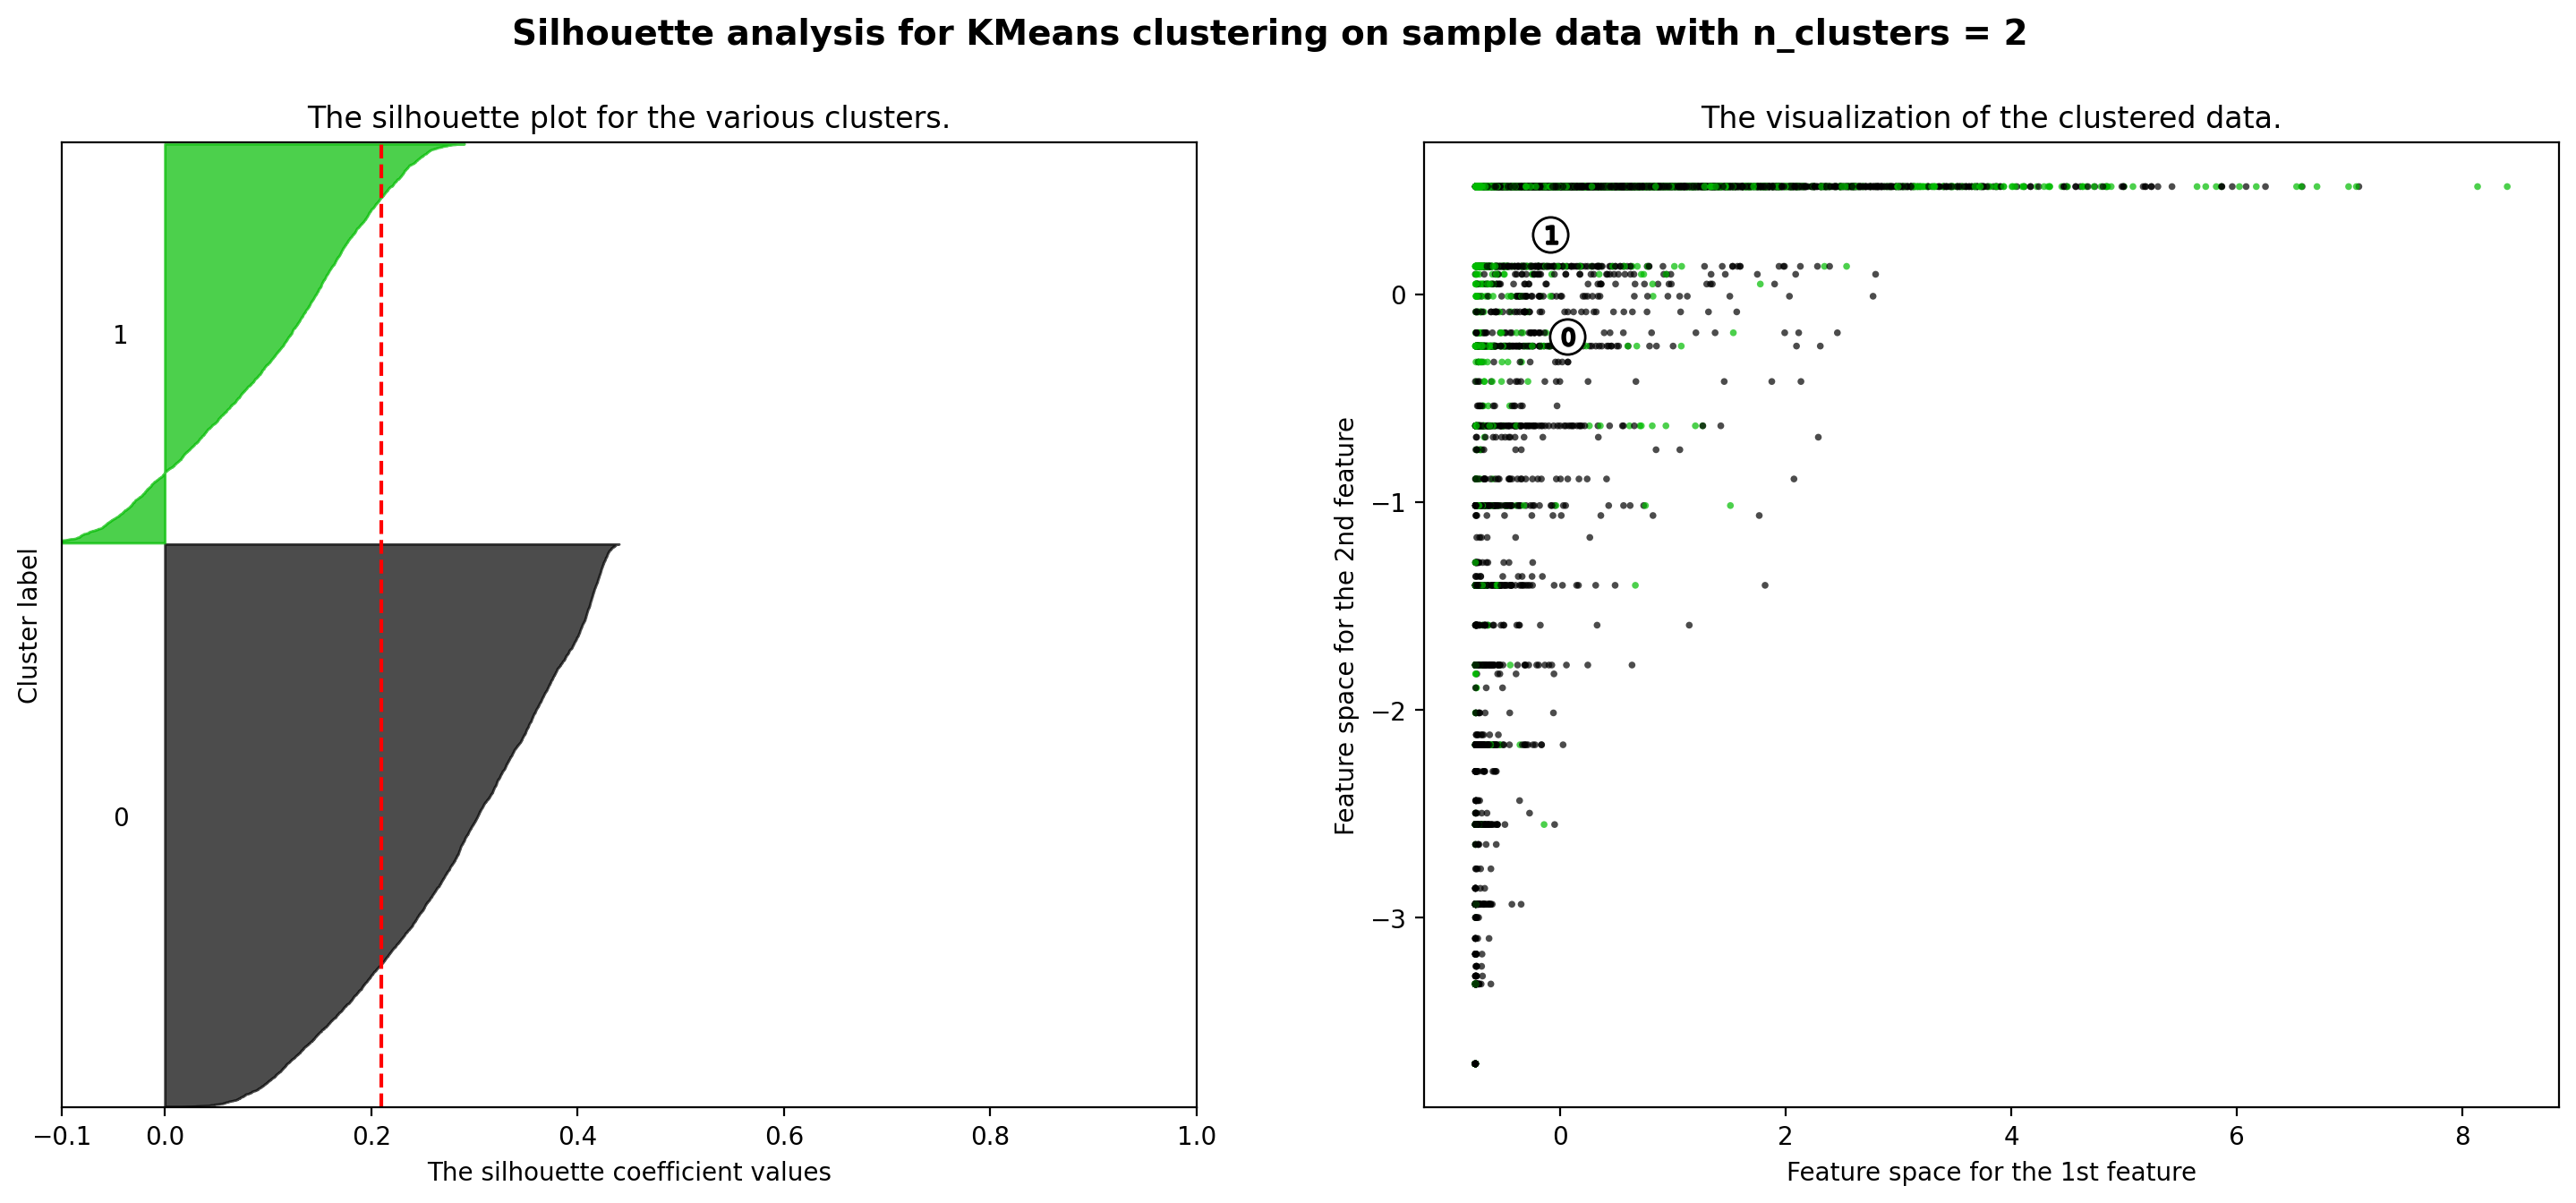

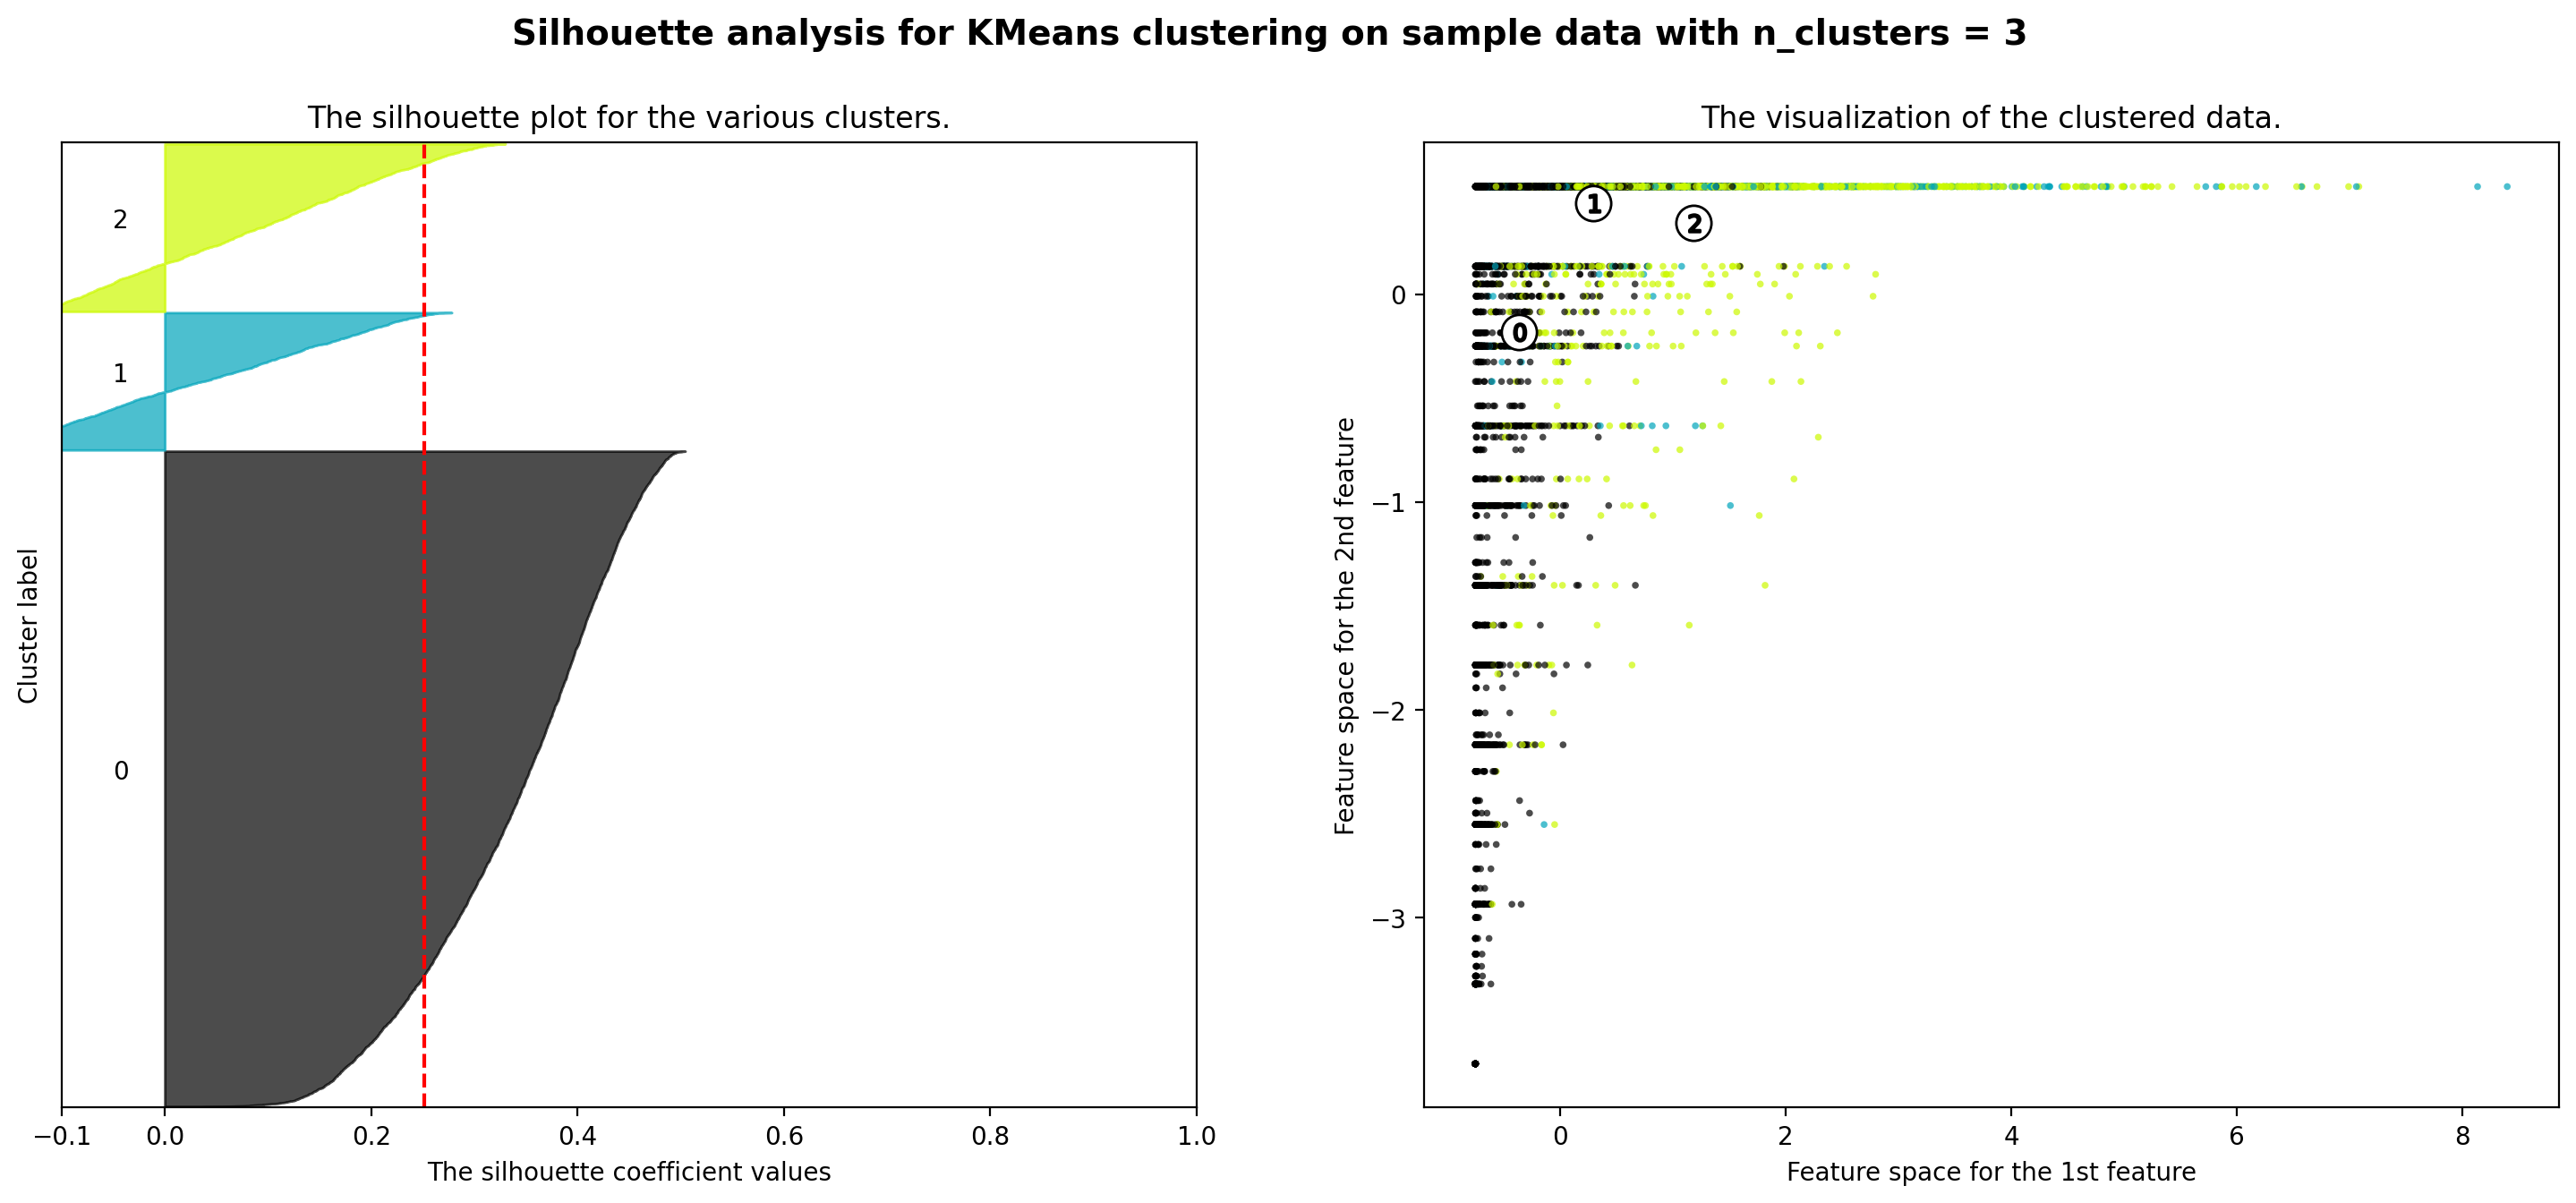

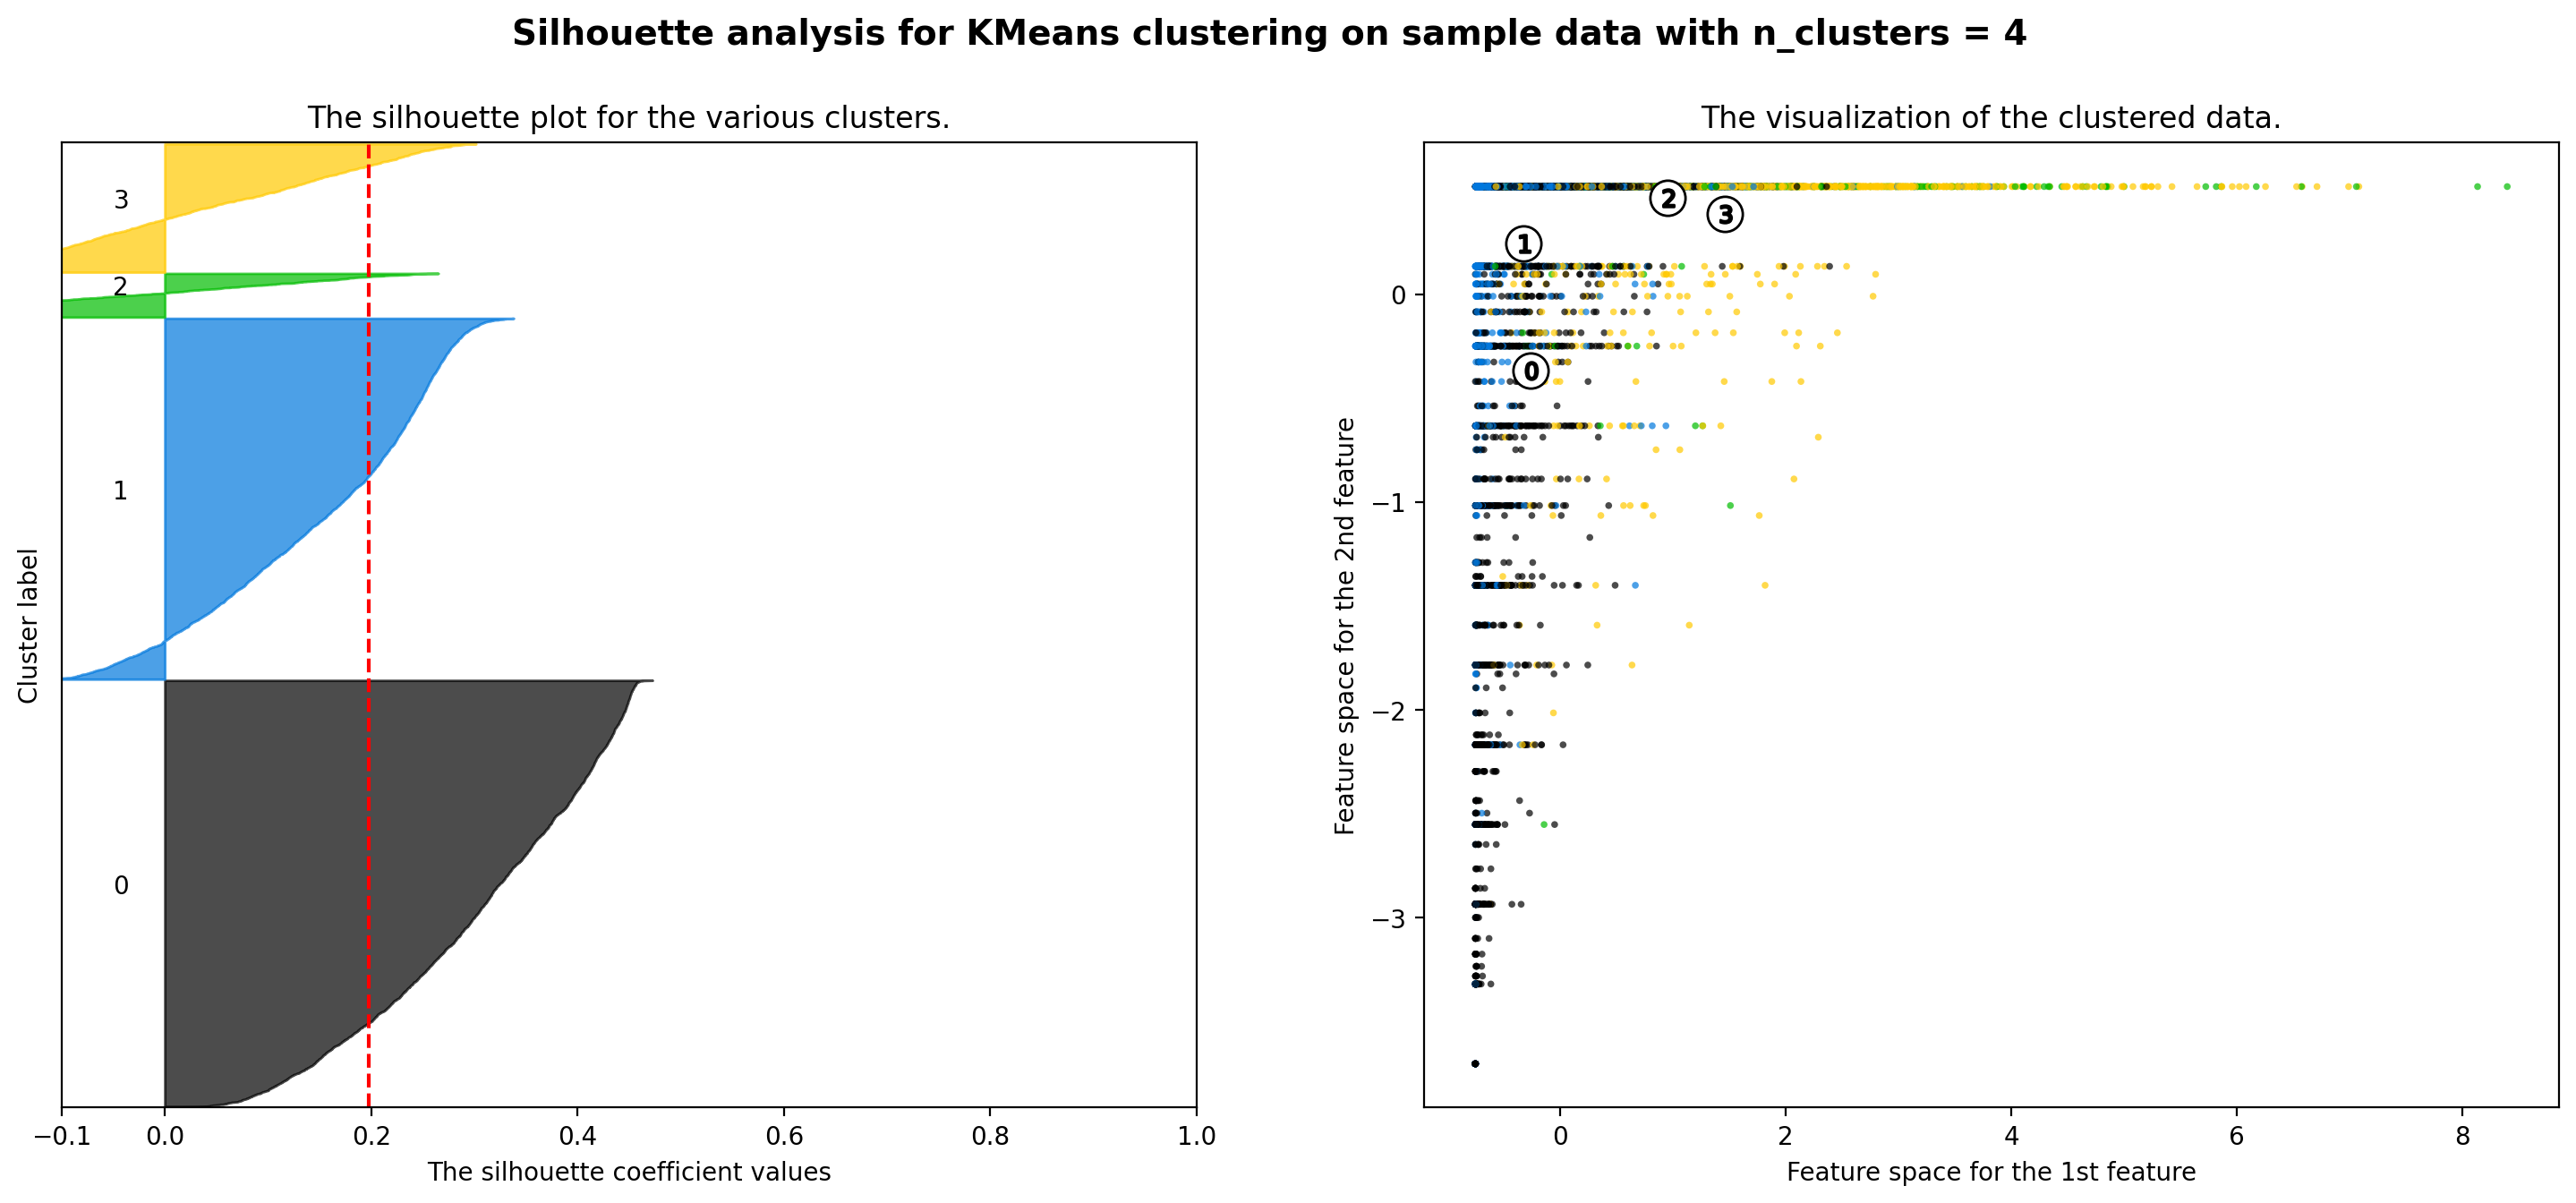

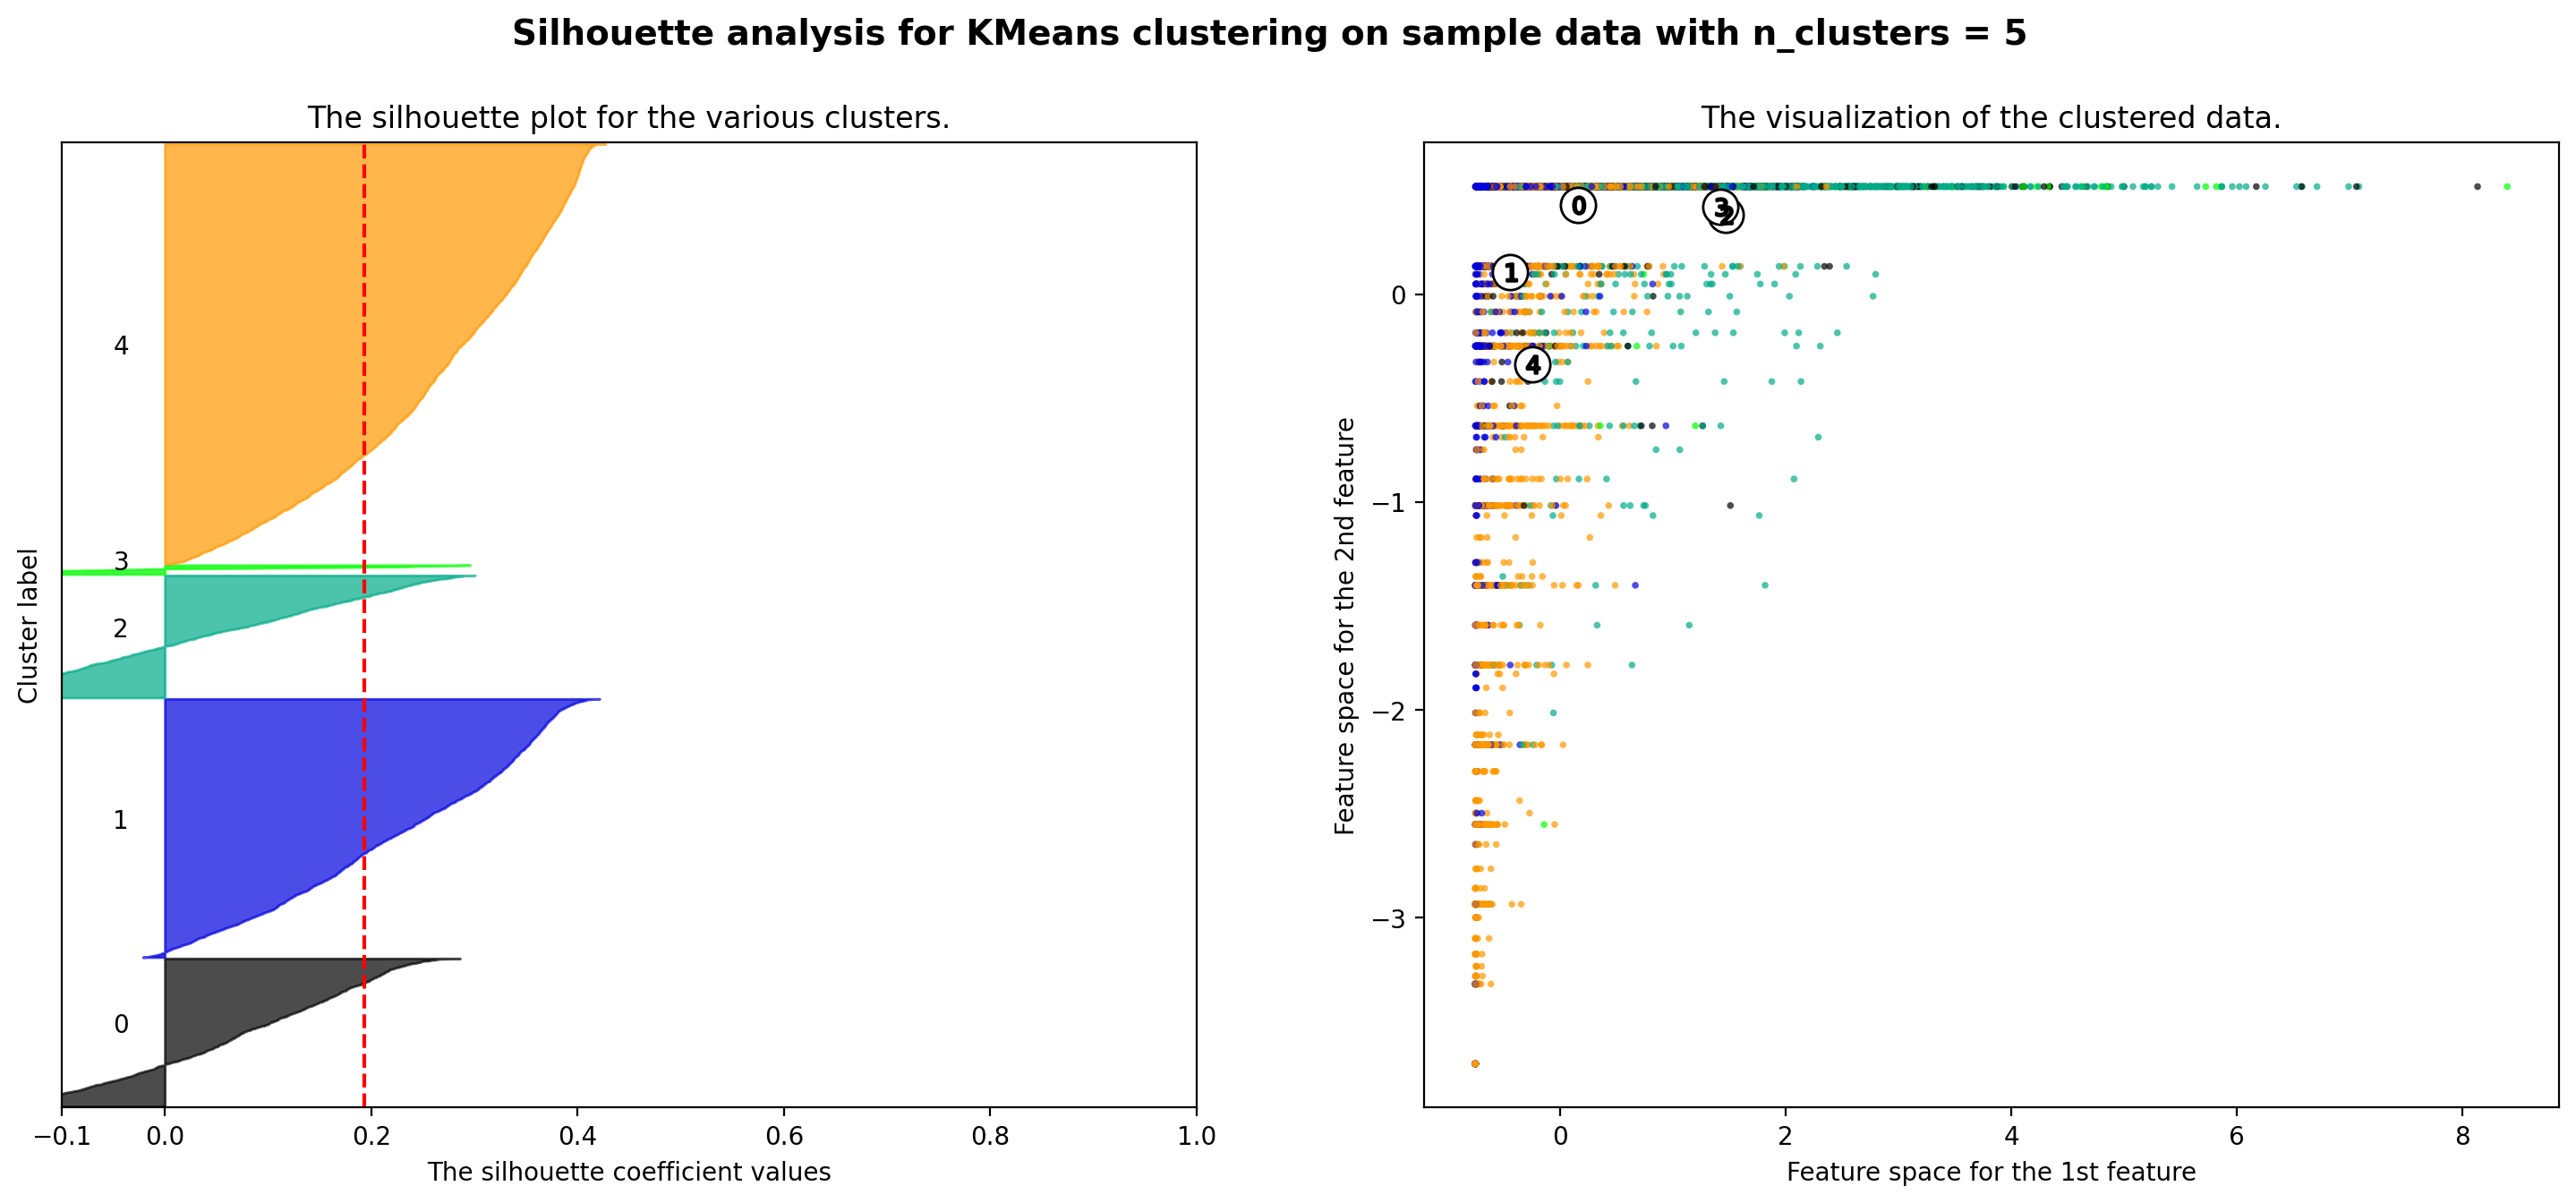

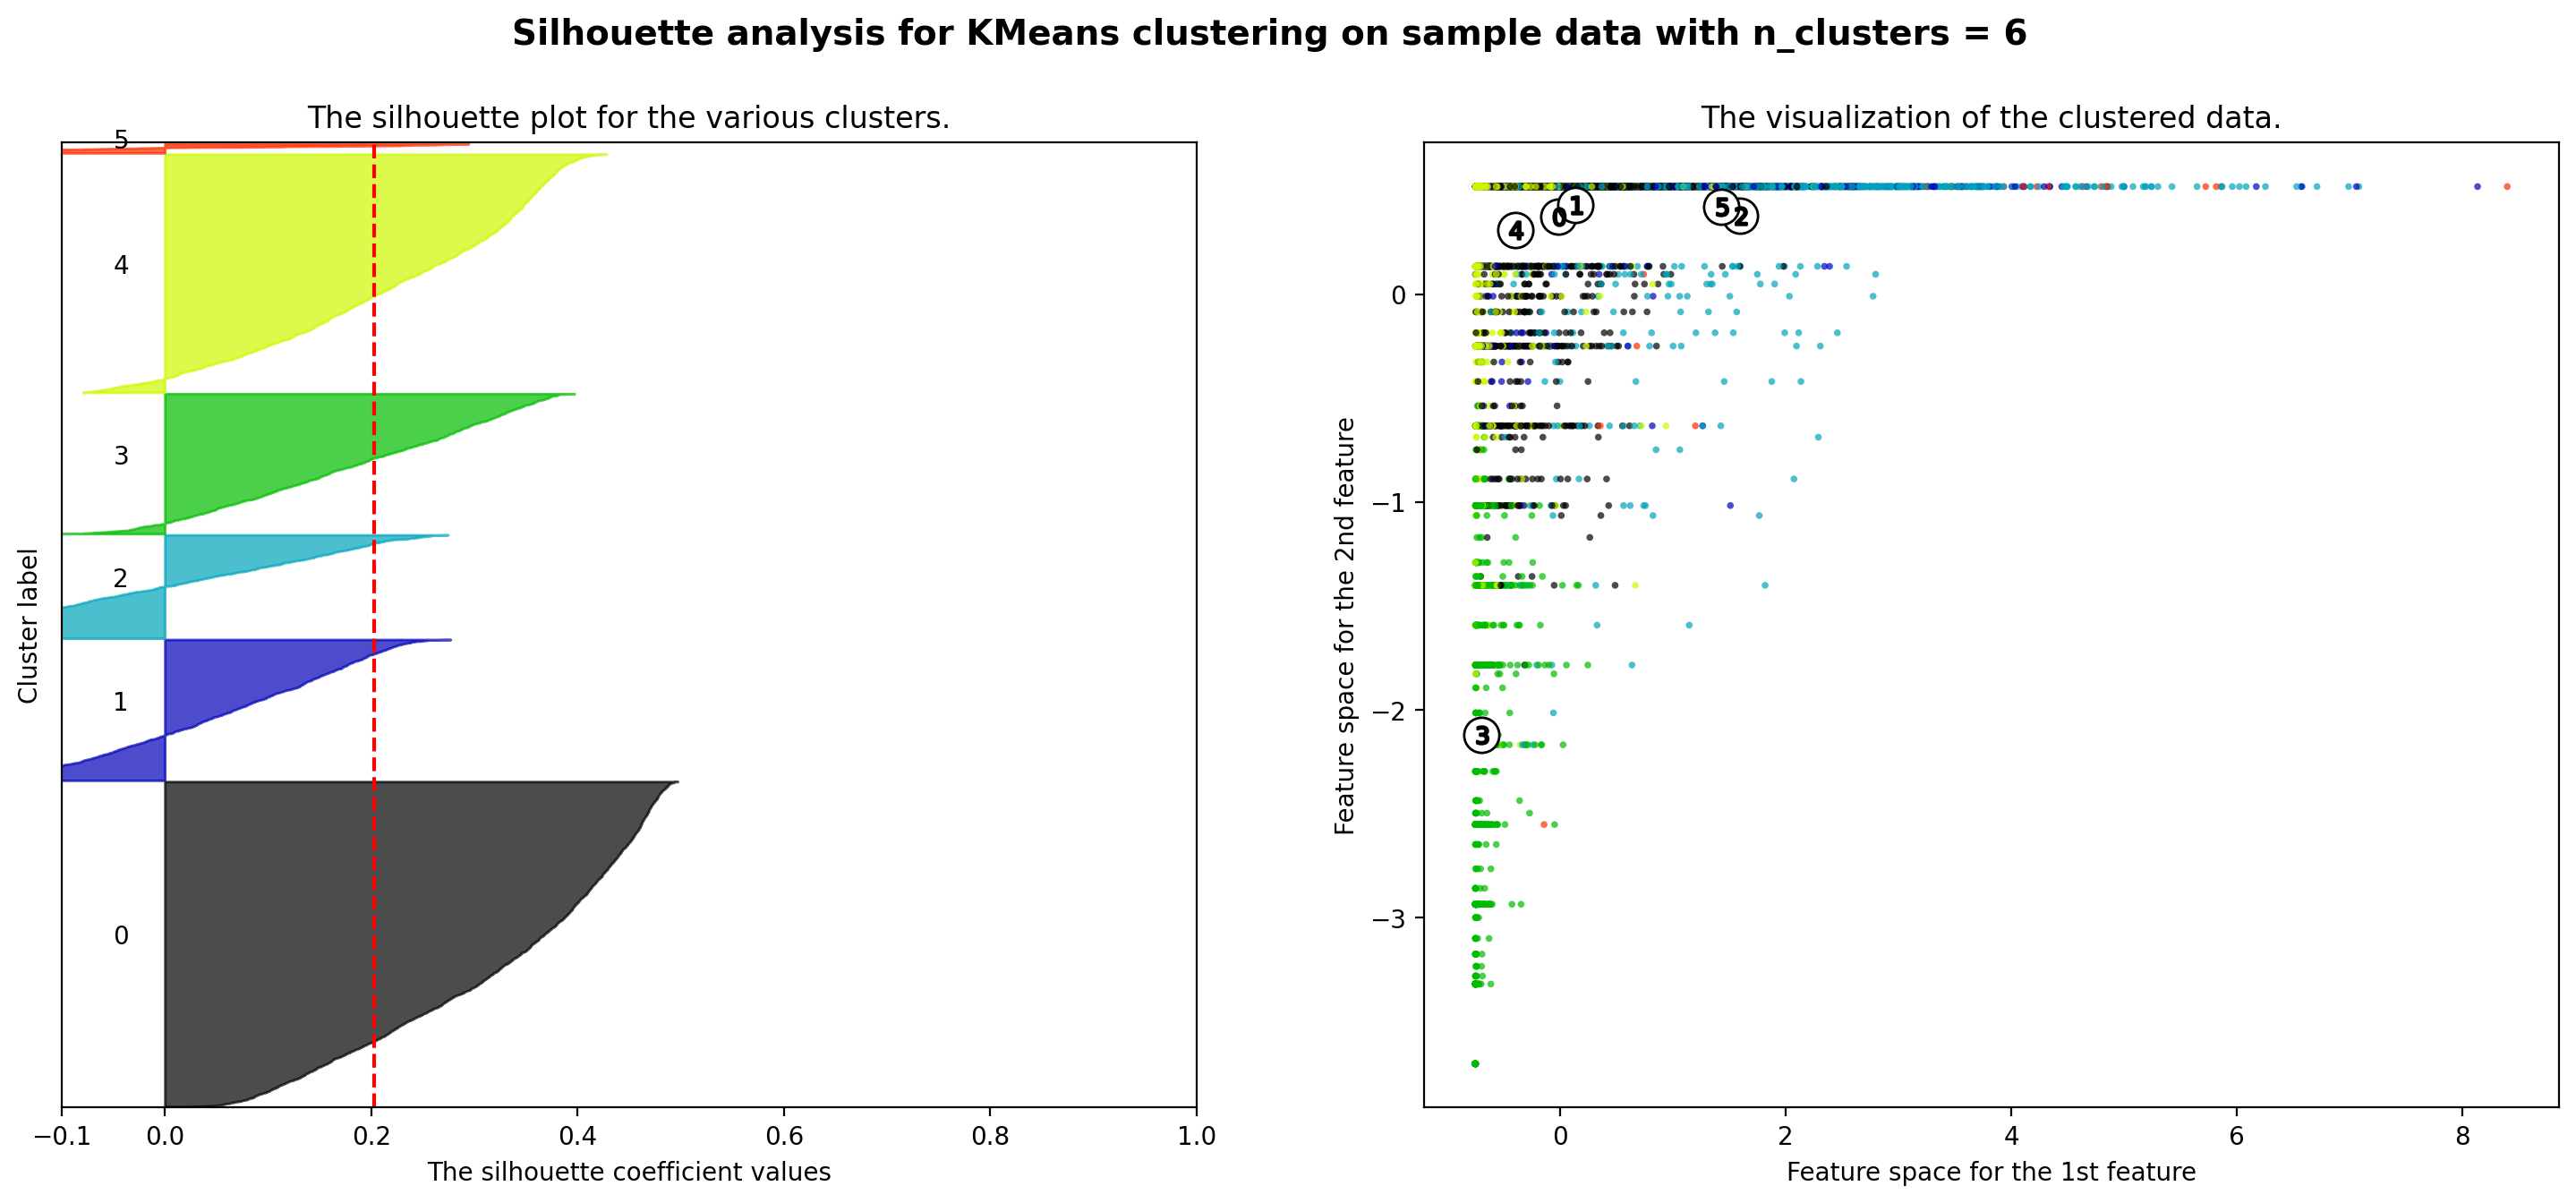

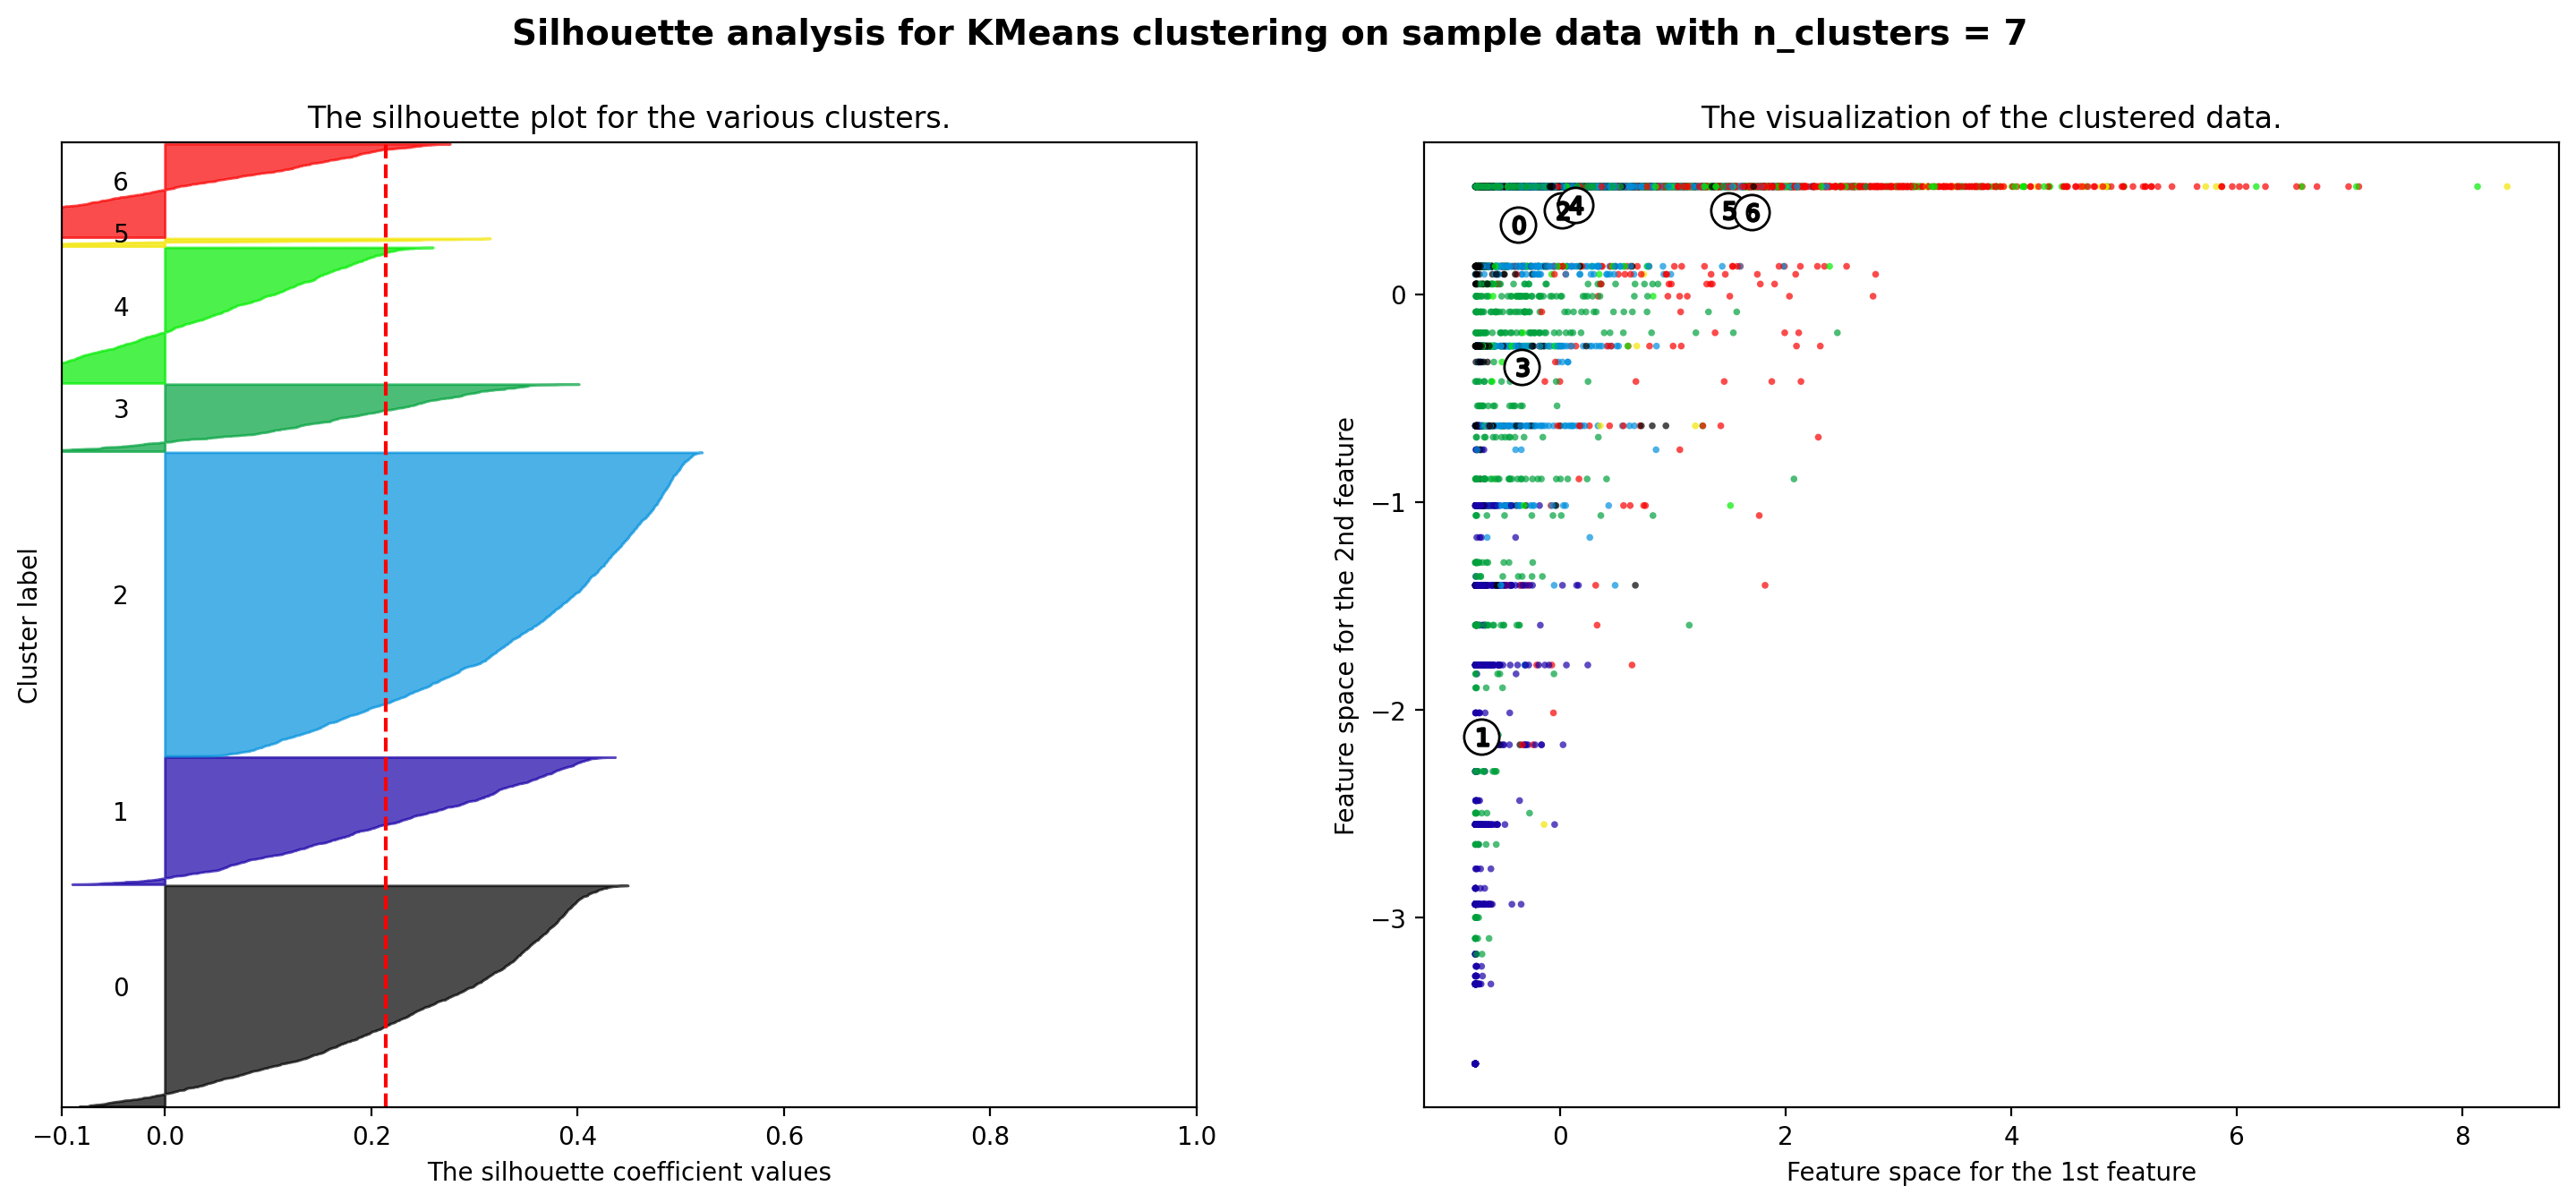

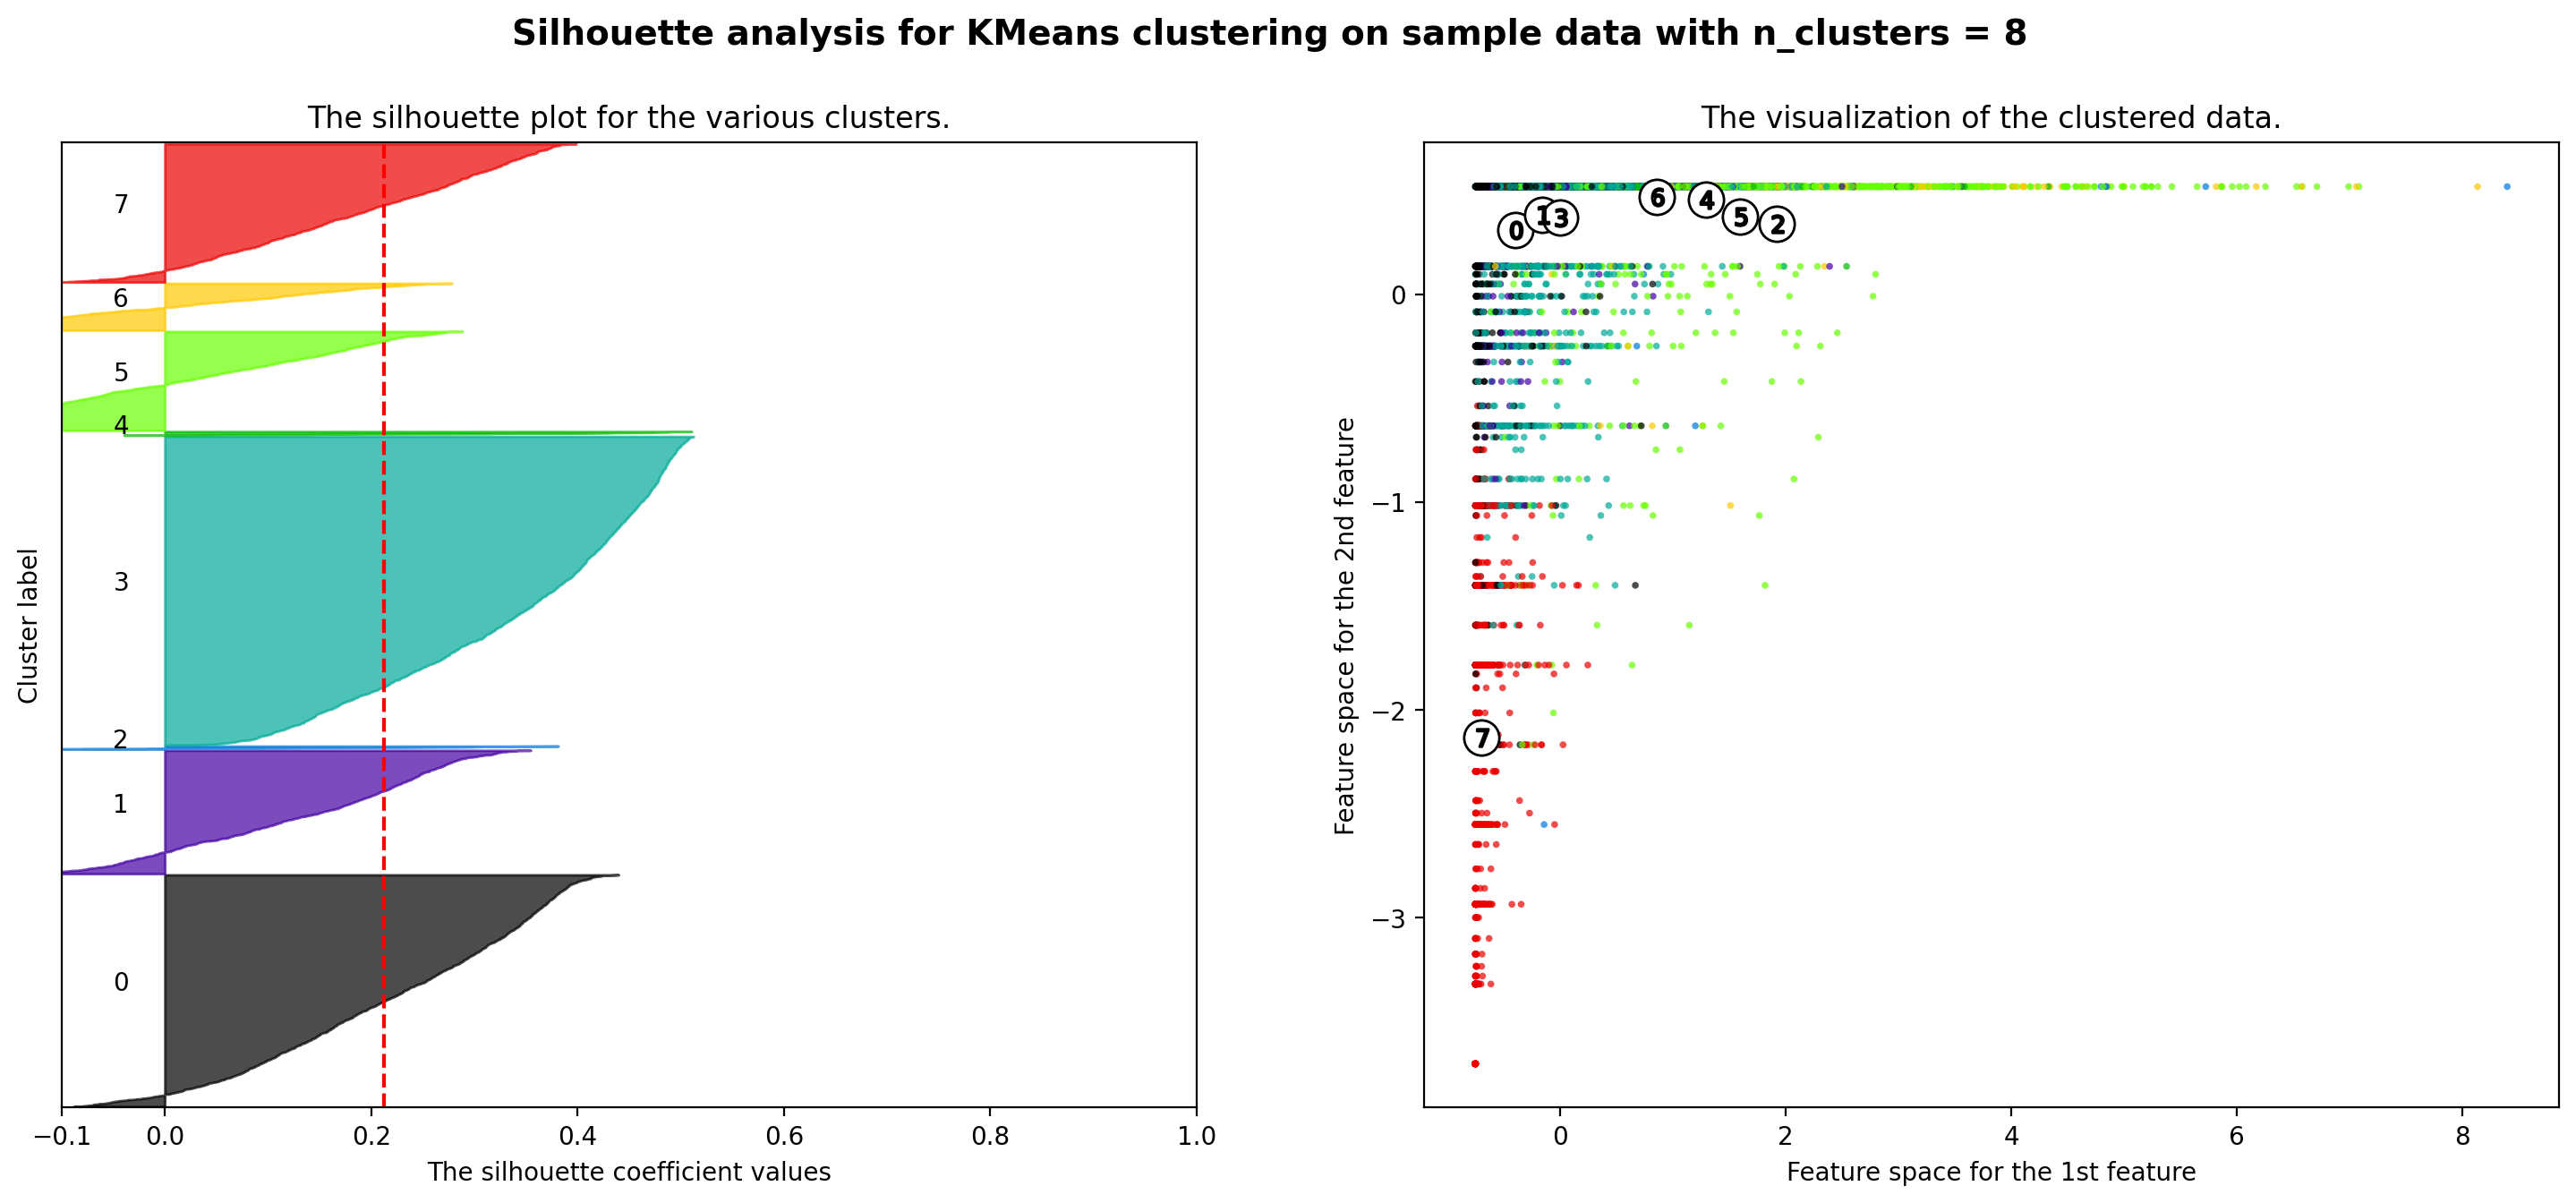

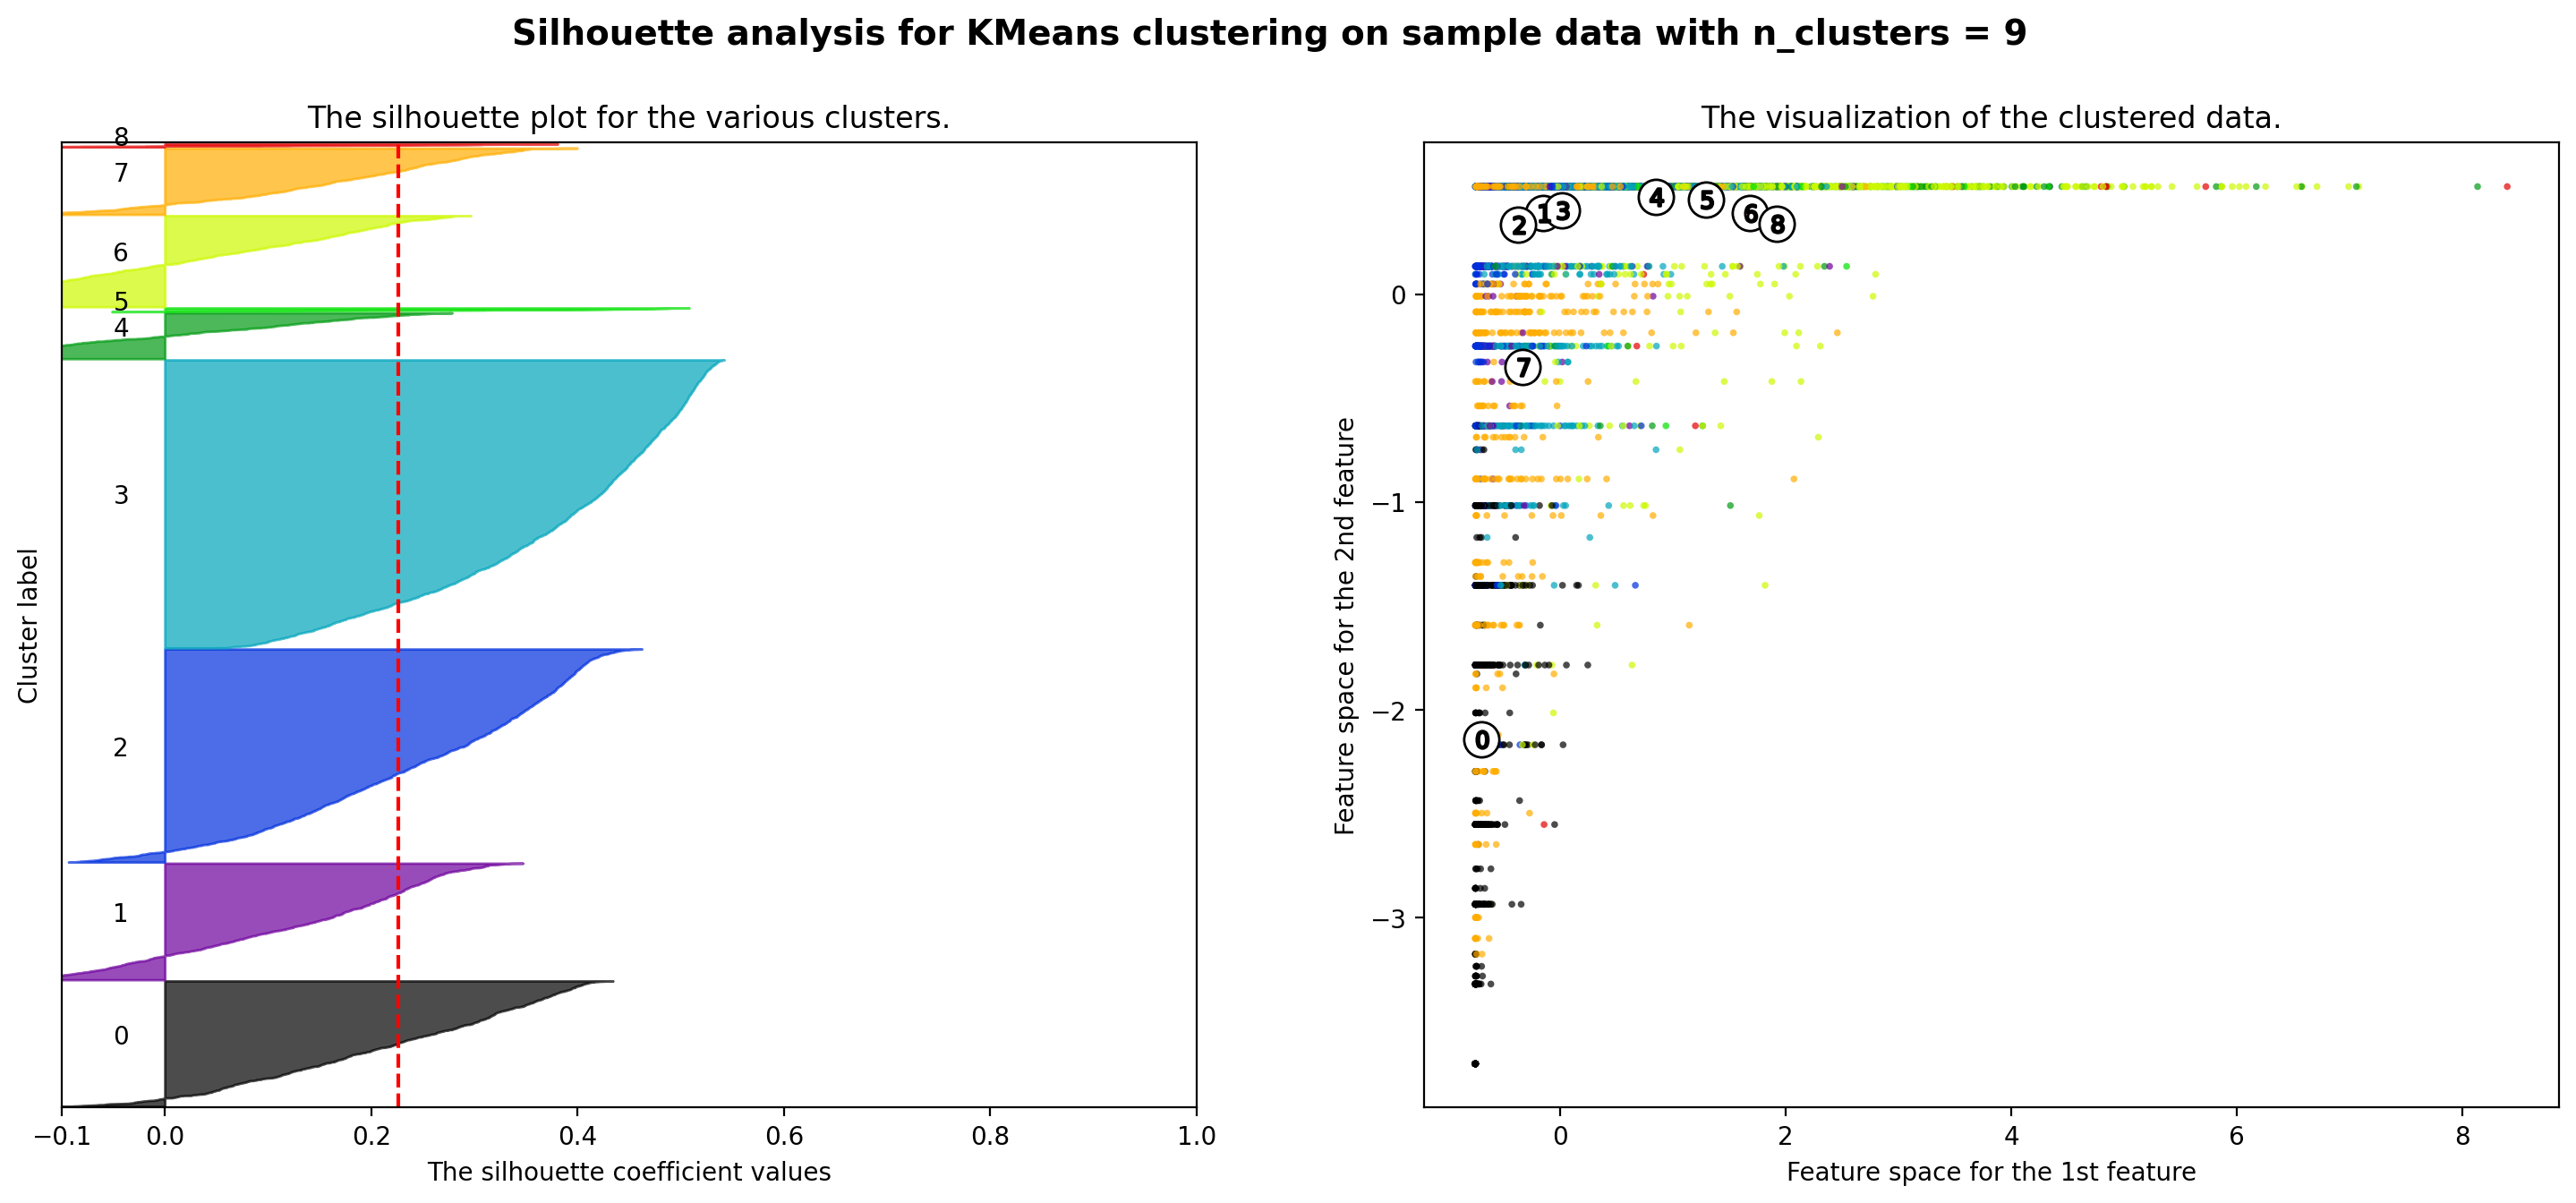

In [8]:
max_n_clusters = 10 # define the max value in the range of k's.

for n_clusters in range(2, max_n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Silhouette score does not give a clear answer so we take the maximum number before it start decreasing (a sort of _elbow method_).

#### Apply the model

In [7]:
kmeans = KMeans(n_clusters = 5, init = "k-means++", random_state = 10)
labels = kmeans.fit_predict(X)

In [8]:
df["cluster"] = labels # add cluster infomration as a new column to the dataframe

In [9]:
cluster_1 = (df['cluster'] == 0)
group1 = df[cluster_1]
group1.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.0
mean,1893.400240,0.979339,2916.566171,1986.694776,930.304921,353.408743,0.923747,0.734122,0.585110,0.058192,1.154624,43.521676,6972.541382,2776.468069,829.333264,0.266129,11.888006,0.0
std,2239.393133,0.073497,1931.271807,1631.815986,1091.869555,870.455703,0.132585,0.262602,0.391254,0.118640,2.721186,32.722760,3996.833531,2209.083403,1904.291250,0.370342,0.642911,0.0
min,0.413670,0.181818,8.400000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,4.000000,300.000000,0.000000,3.197940,0.000000,6.000000,0.0
25%,306.394343,1.000000,1474.310000,837.197500,108.867500,0.000000,0.916667,0.583333,0.166667,0.000000,0.000000,22.000000,4000.000000,1231.409298,185.456347,0.000000,12.000000,0.0
50%,1004.068296,1.000000,2477.290000,1543.940000,605.755000,0.000000,1.000000,0.763889,0.666667,0.000000,0.000000,34.000000,6500.000000,2134.074354,322.033839,0.000000,12.000000,0.0
75%,2720.502928,1.000000,3919.495000,2607.457500,1375.400000,123.742116,1.000000,1.000000,1.000000,0.083333,1.000000,54.000000,9000.000000,3796.520543,907.047330,0.500000,12.000000,0.0
max,18495.558550,1.000000,11994.710000,11994.710000,7571.400000,7894.578816,1.000000,1.000000,1.000000,0.833333,27.000000,309.000000,30000.000000,19714.097280,50260.759470,1.000000,12.000000,0.0


<AxesSubplot:>

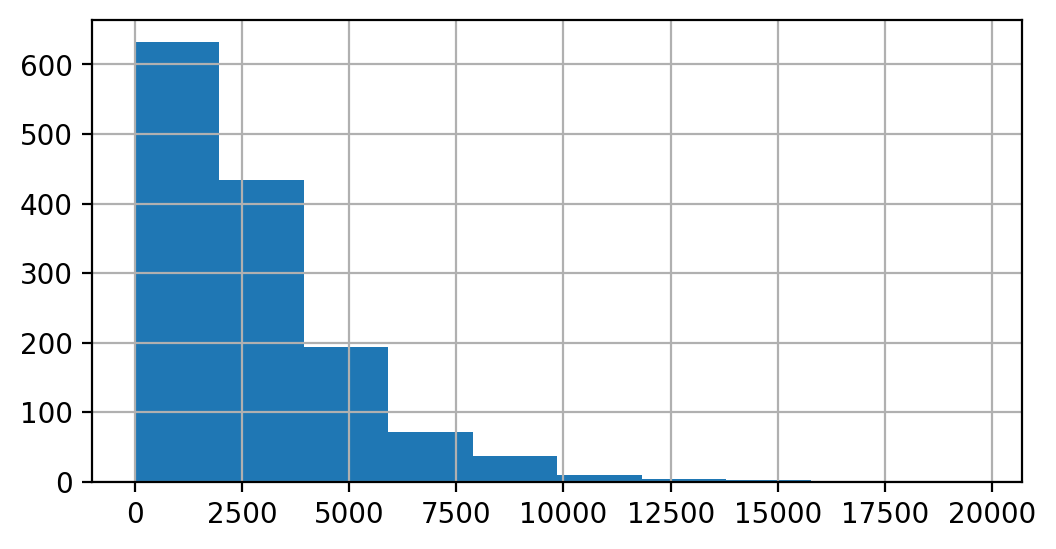

In [10]:
fig = plt.figure(figsize=(6, 3))
group1['PAYMENTS'].hist()

Gruppo 1 (valore 0)
- 75% degli acquisti totali è entro il valore 3919.5                       'PURCHASES'
- 50% dei clienti ha un valore di acquisto una tantum di circa   1544     'ONEOFF_PURCHASES '
- credit limit fra 4000 e 9000                                         'CREDIT_LIMIT ' 25 -> 70
- Pagamenti totali nel periodo tendenzialmente fra 0 e 5500            'PAYMENTS '
- la media del BALANCE 1893.4                                               BALANCE

In [13]:
cluster_2 = (df['cluster'] == 1)
group2 = df[cluster_2]
group2.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.0
mean,645.497179,0.902180,797.770940,166.429623,631.835634,178.096535,0.856571,0.083195,0.794342,0.038047,0.709611,16.645816,3199.588365,934.276591,678.945752,0.271638,11.454847,1.0
std,942.101187,0.199135,670.416839,342.335014,569.428969,534.748139,0.170321,0.141506,0.208637,0.096558,1.957001,11.273641,2529.486316,922.729764,2007.672119,0.353342,1.447031,0.0
min,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.272727,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,0.000000,0.019163,0.000000,6.000000,1.0
25%,45.480317,0.909091,316.812500,0.000000,261.280000,0.000000,0.750000,0.000000,0.666667,0.000000,0.000000,10.000000,1500.000000,332.061027,145.846770,0.000000,12.000000,1.0
50%,180.060319,1.000000,570.450000,0.000000,447.835000,0.000000,0.916667,0.000000,0.833333,0.000000,0.000000,12.000000,2500.000000,654.238477,180.993583,0.083333,12.000000,1.0
75%,992.235762,1.000000,1084.842500,173.095000,802.965000,0.000000,1.000000,0.111111,1.000000,0.000000,0.000000,20.000000,4000.000000,1234.776433,539.366587,0.500000,12.000000,1.0
max,6991.964344,1.000000,4709.140000,3227.850000,4313.220000,5001.962631,1.000000,0.888889,1.000000,0.714286,16.000000,111.000000,18000.000000,8972.867229,38512.124770,1.000000,12.000000,1.0


<AxesSubplot:>

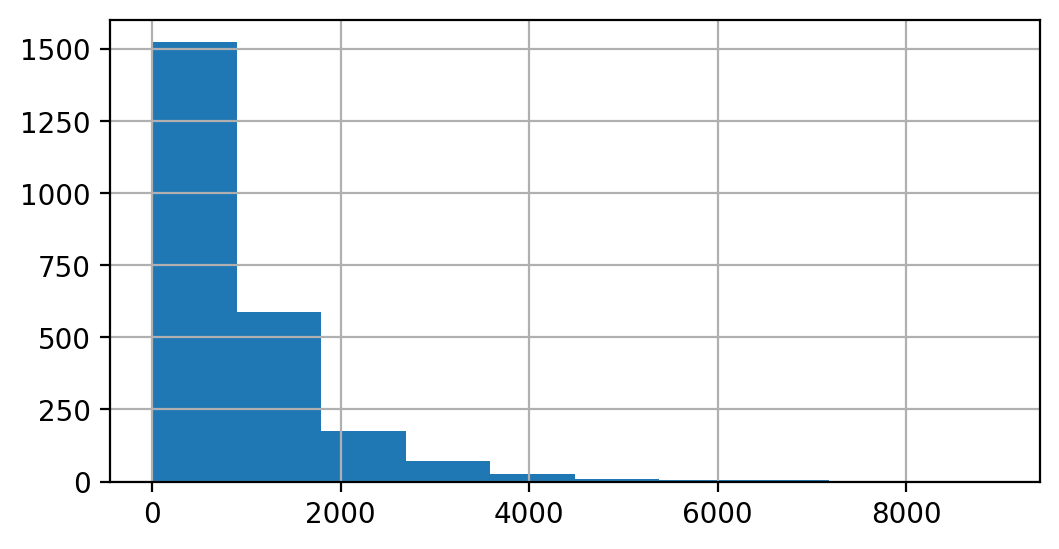

In [14]:
fig = plt.figure(figsize=(6, 3))
group2['PAYMENTS'].hist()

Gruppo 2 (valore 1)
- 75% degli acquisti totali è entro il valore 1084.8                       'PURCHASES'
- 50% dei clienti non ha acquisti una tantum    'ONEOFF_PURCHASES '
- credit limit fra 1500 e 4000                                         'CREDIT_LIMIT ' 25 -> 75
- Pagamenti totali nel periodo tendenzialmente fra 0 e 1800            'PAYMENTS '
- la media del BALANCE 645.4                                               BALANCE

In [15]:
cluster_3 = (df['cluster'] == 2)
group3 = df[cluster_3]
group3.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.0
mean,4627.282112,0.967796,495.799134,303.713902,192.174182,4644.490824,0.281926,0.131190,0.183098,0.492107,14.701662,7.405949,7566.320687,3611.721099,2013.206303,0.036172,11.379703,2.0
std,2771.650416,0.092242,913.231791,661.145671,458.217867,3663.144922,0.351282,0.218773,0.309803,0.227442,12.525046,13.898356,3694.983558,4449.997062,3892.890660,0.104955,1.484069,0.0
min,78.114579,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,16.950090,0.000000,6.000000,2.0
25%,2497.241995,1.000000,0.000000,0.000000,0.000000,2437.275883,0.000000,0.000000,0.000000,0.333333,7.000000,0.000000,5000.000000,1231.955277,752.920036,0.000000,12.000000,2.0
50%,4302.771935,1.000000,81.840000,0.000000,0.000000,3771.115165,0.083333,0.000000,0.000000,0.500000,12.000000,1.000000,7000.000000,2011.126751,1327.669984,0.000000,12.000000,2.0
75%,6259.383965,1.000000,613.055000,293.715000,143.000000,5750.530903,0.545455,0.166667,0.333333,0.666667,18.000000,9.000000,10000.000000,4146.569159,2073.473020,0.000000,12.000000,2.0
max,16304.889250,1.000000,8533.540000,6678.260000,4460.780000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,142.000000,19600.000000,40627.595240,61031.618600,1.000000,12.000000,2.0


<AxesSubplot:>

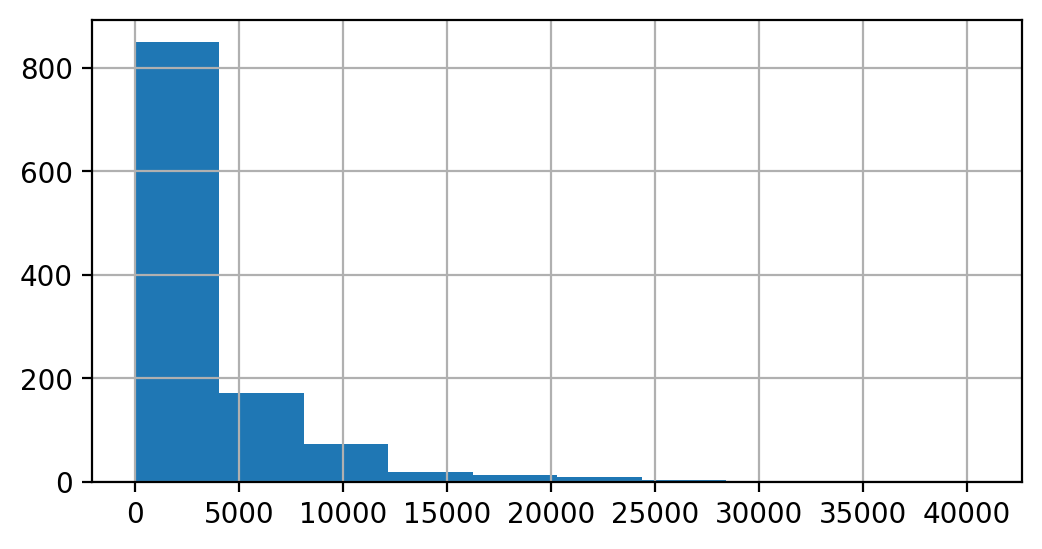

In [16]:
fig = plt.figure(figsize=(6, 3))
group3['PAYMENTS'].hist()

Gruppo 3 (valore 2)
- 75% degli acquisti totali è entro il valore 613                       'PURCHASES'
- 50% dei clienti non ha acquisti una tantum    'ONEOFF_PURCHASES '
- credit limit fra 5000 e 10000                                         'CREDIT_LIMIT ' 25 -> 75
- Pagamenti totali nel periodo tendenzialmente fra 0 e 4000            'PAYMENTS '
- la media del BALANCE 4627.2                                               BALANCE

In [17]:
cluster_4 = (df['cluster'] == 3)
group4 = df[cluster_4]
group4.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.0
mean,4541.393882,0.976638,15777.311395,10689.027791,5088.283605,1060.190695,0.928101,0.763090,0.781501,0.085271,2.988372,130.197674,12493.023256,15581.496801,3383.304083,0.394721,11.965116,3.0
std,3918.343503,0.092778,8721.569456,8982.914509,4378.951420,3191.679741,0.177680,0.303423,0.319788,0.205710,8.634397,79.693356,5293.476356,9646.696712,8866.689365,0.413776,0.239984,0.0
min,348.342172,0.272727,5596.110000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,3.000000,2800.000000,2190.466875,156.683560,0.000000,10.000000,3.0
25%,1403.918288,1.000000,10285.232500,4049.062500,1606.422500,0.000000,1.000000,0.583333,0.604167,0.000000,0.000000,79.000000,9000.000000,9323.955560,342.448619,0.000000,12.000000,3.0
50%,3060.286157,1.000000,11779.945000,9425.015000,4205.970000,0.000000,1.000000,0.916667,0.958333,0.000000,0.000000,121.500000,12000.000000,12037.309790,837.674493,0.250000,12.000000,3.0
75%,6594.376438,1.000000,19802.442500,12917.802500,6977.167500,172.019759,1.000000,1.000000,1.000000,0.083333,1.000000,174.000000,16375.000000,19970.794487,2676.310503,0.864583,12.000000,3.0
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,19513.474830,1.000000,1.000000,1.000000,1.000000,48.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000,3.0


<AxesSubplot:>

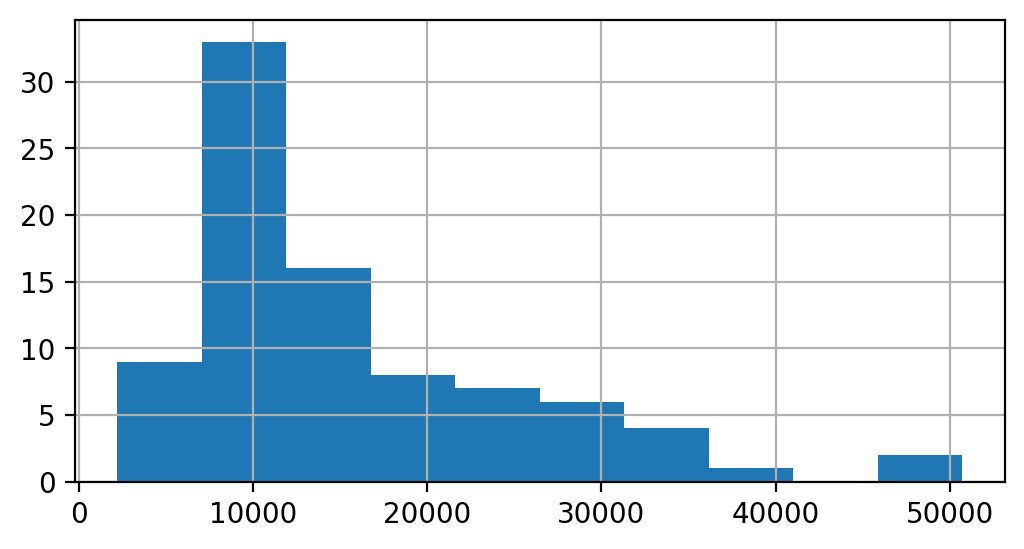

In [18]:
fig = plt.figure(figsize=(6, 3))
group4['PAYMENTS'].hist()

Gruppo 4 (valore 3)
- 75% degli acquisti totali è entro il valore 19802                       'PURCHASES'
- 50% dei clienti ha un valore di acquisto una tantum di circa  9425    'ONEOFF_PURCHASES '
- credit limit fra 9000 e 16375                                         'CREDIT_LIMIT ' 25 -> 75
- Pagamenti totali nel periodo tendenzialmente fra 5000 e 20000            'PAYMENTS '
- la media del BALANCE 4541.3                                              BALANCE

In [19]:
cluster_5 = (df['cluster'] == 4)
group5 = df[cluster_5]
group5.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.000000,3923.0
mean,1056.286071,0.797380,278.559633,225.482134,53.279304,622.488991,0.163230,0.096753,0.065738,0.119130,2.218965,2.950293,3346.626166,1005.724200,600.514227,0.070456,11.455264,4.0
std,1121.494154,0.293336,478.678680,455.570045,150.430275,942.546607,0.184917,0.149886,0.126211,0.139150,3.034264,4.319627,2717.907875,1598.988379,1379.644200,0.194597,1.394871,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,0.037744,0.000000,6.000000,4.0
25%,113.666209,0.636364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500.000000,277.095949,166.039271,0.000000,12.000000,4.0
50%,820.700166,1.000000,72.400000,0.000000,0.000000,145.998161,0.083333,0.000000,0.000000,0.083333,1.000000,1.000000,2500.000000,550.181692,319.173449,0.000000,12.000000,4.0
75%,1563.190261,1.000000,350.000000,246.820000,31.075000,965.912199,0.279220,0.166667,0.083333,0.166667,3.000000,4.000000,4000.000000,1110.723796,668.270121,0.000000,12.000000,4.0
max,8115.039014,1.000000,4900.000000,4900.000000,3000.000000,6523.780195,1.000000,1.000000,0.583333,0.857143,23.000000,54.000000,23000.000000,29272.486070,28483.254830,1.000000,12.000000,4.0


<AxesSubplot:>

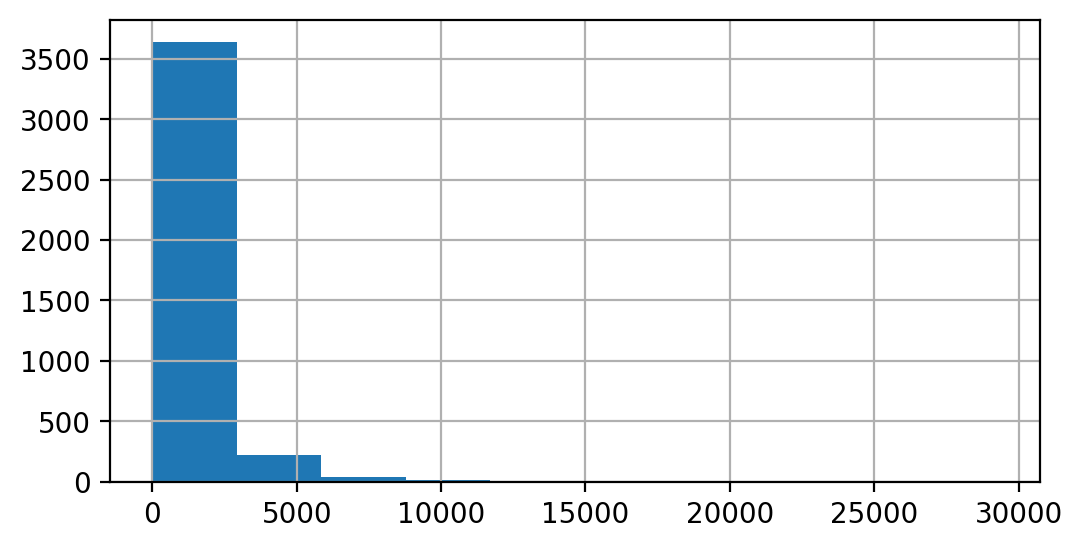

In [20]:
fig = plt.figure(figsize=(6, 3))
group5['PAYMENTS'].hist()

Gruppo 5 (valore 4)
- 75% degli acquisti totali è entro il valore 350                       'PURCHASES'
- 50% dei clienti non ha acquisti una tantum     'ONEOFF_PURCHASES '
- credit limit fra 1500 e 4000                                         'CREDIT_LIMIT ' 25 -> 75
- Pagamenti totali nel periodo tendenzialmente fra 0 e 2500            'PAYMENTS '
- la media del BALANCE 1056                                              BALANCE

#### Visualise clusters

With the prediction results, the first visualization is to review the feature distribution for each cluster.

In [21]:
distrubuzione = df.groupby(df.cluster.rename('segmentation')).agg({'cluster':'count'})

In [22]:
distrubuzione = distrubuzione.reset_index()

In [23]:
cluster_label = dict()
cluster_label = {0:'cluster_1',1:'cluster_2',2:'cluster_3',3:'cluster_4',4:'cluster_5'}

In [24]:
distrubuzione['segmentation'] = distrubuzione['segmentation'].map(cluster_label)

In [25]:
distrubuzione

,segmentation,cluster
0,cluster_1,1384
1,cluster_2,2414
2,cluster_3,1143
3,cluster_4,86
4,cluster_5,3923


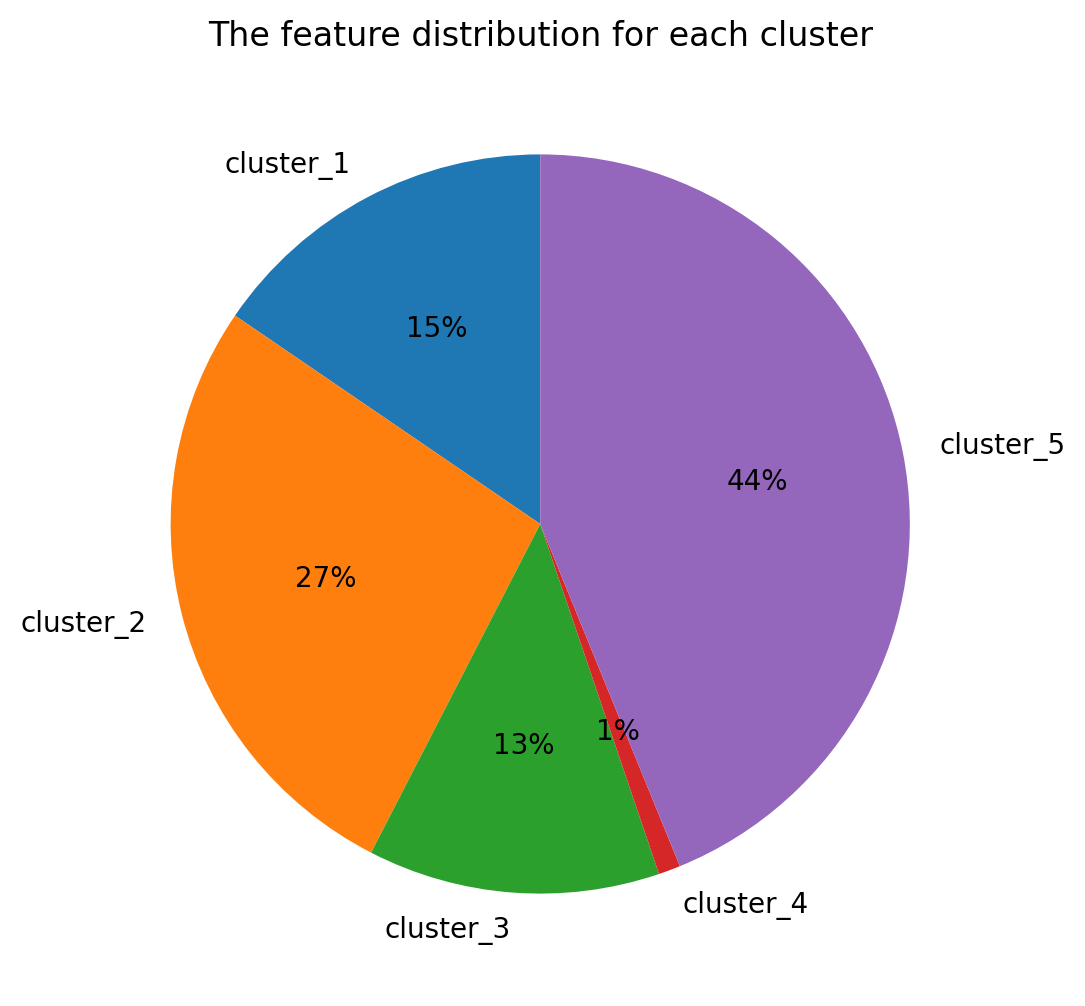

In [26]:
fig = plt.figure(figsize=(12,6))
plt.pie(distrubuzione.cluster, labels = distrubuzione.segmentation, startangle = 90, autopct = "%1.0f%%")
plt.title("The feature distribution for each cluster")
plt.show()